In [9]:
import relay_bp
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt


import sinter
import multiprocessing

import sys
from pathlib import Path

# Make test utilities importable
tests_dir = Path.cwd().parent / "tests"
if str(tests_dir) not in sys.path:
    sys.path.insert(0, str(tests_dir))

# Make BBcode module importable (from qPLDC-circuits/tomas)
# bb_dir = (Path.cwd().parents[2] / "qPLDC-circuits" / "tomas").resolve()
# if str(bb_dir) not in sys.path:
#     sys.path.insert(0, str(bb_dir))
import BBcode

# Import Relay-BP Sinter decoder API
from relay_bp.stim.sinter.decoders import (
    SinterDecoder_RelayBP,
    sinter_decoders,
)

In [10]:
import os, sys, importlib
from pathlib import Path

qasm_dir = "./bb_code_qasm"
os.makedirs(qasm_dir, exist_ok=True)

# Add stabilizer/src to PYTHONPATH using a path relative to this notebook
try:
    base_dir = Path(__file__).resolve().parent
except NameError:
    base_dir = Path.cwd().resolve()
src_dir = (base_dir.parents[3] / "src").resolve()  # .../stabilizer/src
if str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))

import noise_util as ns
importlib.reload(ns)

<module 'noise_util' from '/Users/garn195/Library/CloudStorage/OneDrive-PNNL/Project_Repositories/NWQ-Sim/stabilizer/src/noise_util.py'>

In [11]:
import subprocess
import time

# Compile the C++ code once before the loop
print("Compiling C++ simulator (MPI)...")
# Adjust the path to your C++ file as needed
cpp_file_path = './bb_code_sim.cpp'
executable_path = './bb_code_sim'

compile_command = [
    "/opt/homebrew/bin/mpicxx",  # Use MPI compiler wrapper
    "-std=c++17",
    "-O3",
    "-I../../../../../", # Include for NWQ-Sim headers
    "-DMPI_ENABLED",
    "-o",
    executable_path,
    cpp_file_path
]
try:
    subprocess.run(compile_command, check=True, capture_output=True, text=True)
    print("Compilation successful.")
except subprocess.CalledProcessError as e:
    print("Compilation failed.")
    print("--- stdout ---")
    print(e.stdout)
    print("--- stderr ---")
    print(e.stderr)

Compiling C++ simulator (MPI)...
Compilation successful.


In [12]:

#Params
circuit = "bicycle_bivariate_144_12_12_memory_Z"
distance = 12
rounds = 12
SHOTS = 100

XYZ_decoding = False

# Construct Relay-BP decoder (from decoders.py)
decoder = SinterDecoder_RelayBP(
    gamma0=0.1,
    pre_iter=80,
    num_sets=60,
    set_max_iter=60,
    gamma_dist_interval=(-0.24, 0.66),
    stop_nconv=1,
    parallel=True
    )

# circuit = get_test_circuit(circuit=circuit, distance=distance, rounds=rounds, error_rate=error_rate)
# if not XYZ_decoding:
#     circuit = filter_detectors_by_basis(circuit, "Z")

# circuit.diagram("timeline-svg")


In [13]:
#Parameters
tasks = []
T1 = 10 ** -4
T2 = 10 ** -4
tau = np.array([5*10**-7, 10**-6, 5 * 10**-6, 10**-5, 1.5 * 10**-5, 2 * 10**-5, 2.5 * 10**-5, 3 * 10**-5])
lam = 1/T2 - 1/(2*T1)
p_amp = 1 - np.exp(-tau/T1)
p_phase = 1 - np.exp(-lam*tau)
p_list = (p_amp, p_phase)
base_error = 0.000

bb_code = BBcode.BBcode(
    n=144, k=12, d=12, m=6, l=12,
    A=[[3, 0], [0, 1], [0, 2]],
    B=[[0, 3], [1, 0], [2, 0]],
    shift=[0, 0],
    f=[[0, 0], [1, 0], [2, 0], [3, 0], [6, 0], [7, 0], [8, 0], [9, 0], [1, 3], [5, 3], [7, 3], [11, 3]],
    g=[[1, 0], [2, 1], [0, 2], [1, 2], [2, 3], [0, 4]],
    h=[[0, 0], [0, 1], [1, 1], [0, 2], [0, 3], [1, 3]],
    alpha=[[0, 0], [0, 1], [2, 1], [2, 5], [3, 2], [4, 0]],
    beta=[[0, 1], [0, 5], [1, 1], [0, 0], [4, 0], [5, 2]],
)
print(p_list)
i=0
for p_amp, p_phase in zip(p_amp, p_phase):
    noise_profile = [0,0,0,0]
    circuit = bb_code.build_full_BBcode_circuit(rounds=rounds, noise_profile=noise_profile, observable_type="Z", code_capacity=True)

    #Generate stim circuit
    model = ns.ErrorModel(circuit)
    model.setting_error('Identity', False, f'DEPOLARIZE1({base_error})')
    model.setting_error('Single_qubit', False, f'DEPOLARIZE1({base_error})')
    model.setting_error('Two_qubit', False, f'DEPOLARIZE2({base_error})')
    model.setting_error('Measurement', True, f'PAULI_CHANNEL_1({p_amp/4}, {p_amp/4}, {p_amp/4 + p_phase/2})')
    model.setting_error('Reset', True, f'PAULI_CHANNEL_1({p_amp/4}, {p_amp/4}, {p_amp/4 + p_phase/2})')
    stim_circuit = model.generate_noisy_circuit()


    #Generate stabsim circuit
    model.setting_error('Measurement', True, f'AMPLITUDE_DAMP({p_phase}, {p_amp})')
    model.setting_error('Reset', True, f'AMPLITUDE_DAMP({p_phase}, {p_amp})')
    stab_circuit = model.generate_noisy_circuit()
    qasm_output = ns.stim_to_qasm_with_depolarize_noise(stab_circuit)
    # Inject AMPLITUDE_DAMP around M/RESET in QASM using the model settings
    qasm_output = ns.inject_amplitude_damp(qasm_output, model)
    
    try:
        qasm_path = os.path.join(qasm_dir, f"bb_code_d{distance}_p{i}.qasm")
        with open(qasm_path, "w") as f:
            f.write(qasm_output)
    except Exception as e:
        print(f"Failed to export QASM for p={p_amp}: {e}")
    tasks.append(sinter.Task(circuit=stim_circuit, json_metadata={'d': distance, "trial":i}))
    i+=1


(array([0.00498752, 0.00995017, 0.04877058, 0.09516258, 0.13929202,
       0.18126925, 0.22119922, 0.25918178]), array([0.00249688, 0.00498752, 0.02469009, 0.04877058, 0.07225651,
       0.09516258, 0.1175031 , 0.13929202]))


In [14]:
num_workers = multiprocessing.cpu_count()

def run_stim_experiment(tasks, shots):
    stim_lers = []
    for task in tasks:
        start_time = time.perf_counter()
        p = task.json_metadata.get('p_amp', 0)
        print(f"\n--- Running Stim for p = {p:.1e} ---")
        collected_stats = sinter.collect(
            num_workers=num_workers,
            tasks=[task],
            decoders={'relay-bp': decoder},
            max_shots=shots,
            # max_errors=100,
            print_progress=False,
            custom_decoders={
                'relay-bp': SinterDecoder_RelayBP(
                gamma0=0.1,
                pre_iter=80,
                num_sets=60,
                set_max_iter=60,
                gamma_dist_interval=(-0.24, 0.66),
                stop_nconv=1,
                parallel=True
            )
            },
        )
        stim_time = time.perf_counter() - start_time
        stat = collected_stats[0]
        stim_ler = stat.errors / stat.shots if stat.shots > 0 else 0.0
        stim_lers.append(stim_ler)
        print(f"Stim LER: {stim_ler:.4f}, Sim+Decoding Time: {stim_time:.4f}s")
    return stim_lers

# --- Run Stim-only experiment ---

stim_logical_error_rates = run_stim_experiment(tasks, SHOTS)
print("\nStim complete.")
print("Probabilities:", p_list)
print("Stim LERs:", stim_logical_error_rates)



--- Running Stim for p = 0.0e+00 ---
Stim LER: 0.0000, Sim+Decoding Time: 1.8841s

--- Running Stim for p = 0.0e+00 ---
Stim LER: 0.0000, Sim+Decoding Time: 0.6163s

--- Running Stim for p = 0.0e+00 ---
Stim LER: 0.0000, Sim+Decoding Time: 0.6276s

--- Running Stim for p = 0.0e+00 ---
Stim LER: 0.1100, Sim+Decoding Time: 0.9436s

--- Running Stim for p = 0.0e+00 ---
Stim LER: 0.4400, Sim+Decoding Time: 1.1333s

--- Running Stim for p = 0.0e+00 ---
Stim LER: 0.7800, Sim+Decoding Time: 1.4685s

--- Running Stim for p = 0.0e+00 ---
Stim LER: 0.9600, Sim+Decoding Time: 1.6979s

--- Running Stim for p = 0.0e+00 ---
Stim LER: 1.0000, Sim+Decoding Time: 1.7034s

Stim complete.
Probabilities: (array([0.00498752, 0.00995017, 0.04877058, 0.09516258, 0.13929202,
       0.18126925, 0.22119922, 0.25918178]), array([0.00249688, 0.00498752, 0.02469009, 0.04877058, 0.07225651,
       0.09516258, 0.1175031 , 0.13929202]))
Stim LERs: [0.0, 0.0, 0.0, 0.11, 0.44, 0.78, 0.96, 1.0]


In [15]:
from concurrent.futures import ProcessPoolExecutor
from relay_bp.stim.sinter.decoders import SinterCompiledDecoder_BP

num_workers = multiprocessing.cpu_count()

def run_cpp_experiment(tasks, shots):
    cpp_lers = []
    if not tasks:
        return cpp_lers

    # Compile converters/decoder ONCE (structure is identical across p)


    for task in tasks:
        trial = task.json_metadata.get("trial")
        d = distance

        ref_circ = task.circuit
        m2d_converter = ref_circ.compile_m2d_converter()
        dem = ref_circ.detector_error_model(
            decompose_errors=True,
            ignore_decomposition_failures=True,
        )
        compiled = decoder.compile_decoder_for_dem(dem=dem)
        
        print(f"\n--- Running C++ (MPI) for trial {trial} ---")

        # Paths
        qasm_file_path = os.path.join(qasm_dir, f"bb_code_d{d}_p{trial}.qasm")
        cpp_output_path = os.path.join(qasm_dir, f"measurements_d{d}_p{trial}.txt")

        # MPI execution
        num_qubits = task.circuit.num_qubits
        mpi_ranks = max(1, min(os.cpu_count() or 1, shots))  # don't spawn more ranks than shots
        iters = shots

        env = os.environ.copy()
        env.update({
            "OMP_NUM_THREADS": "1",
            "OPENBLAS_NUM_THREADS": "1",
            "MKL_NUM_THREADS": "1",
            "VECLIB_MAXIMUM_THREADS": "1",
            "NUMEXPR_NUM_THREADS": "1",
        })

        run_command = [
            "/opt/homebrew/bin/mpirun", "-np", str(mpi_ranks),
            "./bb_code_sim", str(num_qubits), str(iters), qasm_file_path, cpp_output_path
        ]

        cpp_time = 0.0
        try:
            result = subprocess.run(run_command, check=True, capture_output=True,text=True, env=env)
            for line in result.stdout.strip().split('\n'):
                if "Total C++ simulation time" in line:
                    try:
                        cpp_time = float(line.split(':')[1].strip().replace('s', ''))
                    except (ValueError, IndexError):
                        pass
        except subprocess.CalledProcessError as e:
            print("C++ simulation failed to execute.")
            print("Return code:", e.returncode)
            print("--- stdout ---")
            print(e.stdout)
            print("--- stderr ---")
            print(e.stderr)
            cpp_lers.append(0.0)
            continue

        # Decode with the same Relay-BP decoder used for Stim via a compiled decoder
        try:
            # 1) Load raw measurement strings -> bool array [shots, num_measurements]
            with open(cpp_output_path, "r") as f:
                measurement_strings = [line for line in f.read().strip().split('\n') if line]

            if not measurement_strings:
                cpp_lers.append(0.0)
                print("No C++ measurements found; LER set to 0.0")
                continue

            # Faster parsing and fewer copies
            measurement_data = np.array(
                [list(map(int, line.split())) for line in measurement_strings],
                dtype=np.uint8,
            ).astype(bool, copy=False)

            # 2) Convert measurements -> detection events + observables (compiled once)
            det_samples, obs_flips = m2d_converter.convert(
                measurements=measurement_data,
                separate_observables=True,
            )

            # 3) Bit-pack detection events for compiled decoder API
            det_u8 = det_samples.astype(np.uint8, copy=False)
            bit_packed = np.packbits(det_u8, axis=1, bitorder="little")
            bit_packed = np.ascontiguousarray(bit_packed)

            # 4) Batch decode
            start_time = time.perf_counter()
            pred_obs_b8 = compiled.decode_shots_bit_packed(
                bit_packed_detection_event_data=bit_packed
            )
            pred_obs = np.unpackbits(pred_obs_b8, bitorder="little", axis=1)[:, : dem.num_observables]
            stab_decode_time = time.perf_counter() - start_time

            total_errors = int(np.any(pred_obs != obs_flips.astype(np.uint8), axis=1).sum())
            cpp_ler = float(total_errors) / float(len(det_samples)) if len(det_samples) else 0.0
        except Exception as e:
            print("C++ decoding failed:", e)
            cpp_ler = 1.0

        cpp_lers.append(cpp_ler)
        print(f"C++ LER: {cpp_ler:.4f}, Sim Time: {cpp_time:.4f}s, Decoding Time {stab_decode_time:.4f}s")
    return cpp_lers

# --- Run C++-only experiment ---
cpp_logical_error_rates = run_cpp_experiment(tasks, SHOTS)
print("\nC++ complete.")
print("Probabilities:", p_list)
print("C++ LERs:", cpp_logical_error_rates)



--- Running C++ (MPI) for trial 0 ---
C++ LER: 0.0000, Sim Time: 0.3267s, Decoding Time 0.0014s

--- Running C++ (MPI) for trial 1 ---
C++ LER: 0.0000, Sim Time: 0.3103s, Decoding Time 0.0015s

--- Running C++ (MPI) for trial 2 ---
C++ LER: 0.0000, Sim Time: 0.3568s, Decoding Time 0.0025s

--- Running C++ (MPI) for trial 3 ---
C++ LER: 0.0200, Sim Time: 0.3522s, Decoding Time 0.1211s

--- Running C++ (MPI) for trial 4 ---
C++ LER: 0.2100, Sim Time: 0.3296s, Decoding Time 0.2708s

--- Running C++ (MPI) for trial 5 ---
C++ LER: 0.4900, Sim Time: 0.3298s, Decoding Time 0.4876s

--- Running C++ (MPI) for trial 6 ---
C++ LER: 0.8300, Sim Time: 0.3631s, Decoding Time 0.9084s

--- Running C++ (MPI) for trial 7 ---
C++ LER: 0.9200, Sim Time: 0.3377s, Decoding Time 0.9398s

C++ complete.
Probabilities: (array([0.00498752, 0.00995017, 0.04877058, 0.09516258, 0.13929202,
       0.18126925, 0.22119922, 0.25918178]), array([0.00249688, 0.00498752, 0.02469009, 0.04877058, 0.07225651,
       0.09516

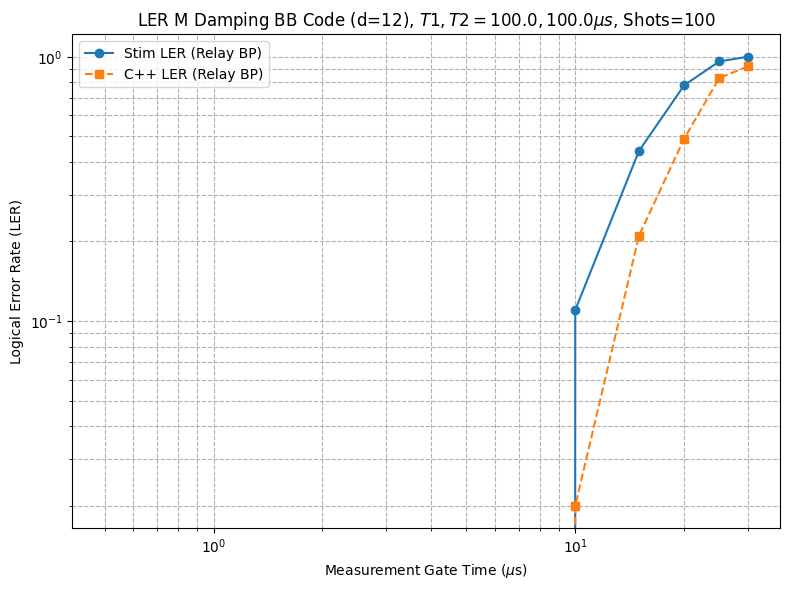

In [16]:
# --- Plotting Results ---
plt.figure(figsize=(8, 6))

plt.plot(tau*10**6, stim_logical_error_rates, 'o-', label='Stim LER (Relay BP)')
plt.plot(tau*10**6, cpp_logical_error_rates, 's--', label='C++ LER (Relay BP)')
plt.xlabel(r"Measurement Gate Time ($\mu$s)")
plt.ylabel("Logical Error Rate (LER)")
plt.title(rf"LER M Damping BB Code (d={distance}), $T1,T2 = {T1*10**6},{T2*10**6}\mu s$, Shots={SHOTS}")
plt.xscale('log')
plt.yscale('log')
plt.xlim()
# plt.xticks(p_list_extend, [f"{p:.0e}" for p in p_list_extend])
plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.savefig(f'../../../figures/BB_code_LER{SHOTS}.pdf', dpi=500, bbox_inches='tight')
plt.show()
